In [233]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pytesseract
%matplotlib inline

In [234]:
def draw(c):
    try:
        c = cv2.cvtColor(c, cv2.COLOR_BGR2RGB)
    except:
        c = cv2.cvtColor(c, cv2.COLOR_GRAY2RGB)
    plt.imshow(c)
    plt.show()

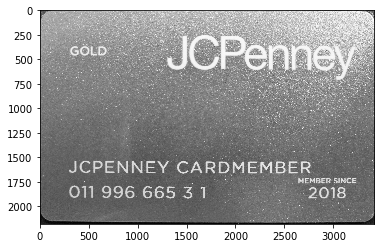

In [289]:
img = cv2.imread("Gold PLC (1).jpg",0)
draw(img)

In [445]:
def valid_Card_Number(number_string):
    
    # Replace all spaces to avoid inconsistency
    number_string = number_string.replace(" ", "")
    
    # MasterCard has aaaa bbbb cccc dddd
    # while PLC has aaa bbb ccc d e
    if len(number_string) == 16:
        
        # do Luhn Algorithm
        try:
            s = list(map(int, number_string))
            LUHN_ODD_LOOKUP = (0, 2, 4, 6, 8, 1 + 0, 1 + 2, 1 + 4, 1 + 6, 1 + 8)
            evens = sum(p for p in s[-1::-2])
            odds = sum(LUHN_ODD_LOOKUP[p] for p in s[-2::-2])
            if ((evens + odds) % 10 == 0):
                return number_string, True, "MasterCard"
        except:
            pass
        
    elif len(number_string) == 11:
        
        # do Luhn Algorithm
        try:
            s = list(map(int, number_string))
            return number_string, True, "Private Card"
        except:
            pass
        
    return number_string, False, "InValid"

In [446]:
def take_threshold(img):
    # Do Otsu binary threshould to create a black-white one.
    ret, img = cv2.threshold(img, 0, 255, cv2.THRESH_OTSU)
    
    # Credit Card fonts are white on black: Reverse it to black on white.
    img = 255 - img
    
    # Do Gaussian Filtering
    kernel_size = 3
    kernel = np.ones((kernel_size,kernel_size),np.float32)/kernel_size/kernel_size
    img = cv2.filter2D(img,-1,kernel)
    
    return img

In [447]:
def recognize(img):
    rows, cols = img.shape[0:2]
    if rows > cols:
        dst = np.rot90(img)
    else:
        dst = img
    
    # Resize the picture into the standard size of Credit Card
    # 85.6mm * 53.9mm -> 856px * 540px
    
    dst = cv2.resize(dst, (856, 540))
    
    # Cut card number
    card_number_pic = dst[430:490,50:600]
    # draw(card_number_pic)
    card_number_pic = take_threshold(card_number_pic)
    card_number_str = pytesseract.image_to_string(card_number_pic, config='outputbase digits')
    
    # identify its validity
    card_number_str, card_valid, card_type = valid_Card_Number(card_number_str)
    if not card_valid:
        return {
            "card_number": card_number_str,
            "card_validity": "InValid"
        }
    
    # cut the cardholder portion
    if card_type == "Private Card":
        card_holder_pic = dst[360:425,50:800]
    elif card_type == "MasterCard":
        card_holder_pic = dst[290:360,50:750]
        
    # draw(card_holder_pic)
    
    card_holder_pic = take_threshold(card_holder_pic)
    
    # draw(card_holder_pic)
    
    card_holder_str = pytesseract.image_to_string(card_holder_pic)
    
    # Remove invalid character in the head and tail
    while card_holder_str[0] in " -":
        card_holder_str = card_holder_str[1:]
    while card_holder_str[-1] in " -":
        card_holder_str = card_holder_str[:-1]
    
    return {
        "card_number": card_number_str,
        "card_validity": card_valid,
        "card_type": card_type,
        "card_holder": card_holder_str
    }

In [448]:
print(recognize(cv2.imread("Red PLC (1).jpg",0)))
print(recognize(cv2.imread("Gold PLC (1).jpg",0)))
print(recognize(cv2.imread("Red MasterCard (1).jpg",0)))

{'card_number': '01199668281', 'card_validity': True, 'card_type': 'Private Card', 'card_holder': 'JCPENNEY CARDMEMBER'}
{'card_number': '01199666531', 'card_validity': True, 'card_type': 'Private Card', 'card_holder': 'JCPENNEY CARDMEMBER'}
{'card_number': '5466801019968970', 'card_validity': True, 'card_type': 'MasterCard', 'card_holder': 'JCPENNEY CARDMEMBER'}
